In [4]:
pip install kagglehub


In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jacksoncrow/stock-market-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'stock-market-dataset' dataset.
Path to dataset files: /kaggle/input/stock-market-dataset


In [6]:
import os

os.listdir(path)



['stocks', 'symbols_valid_meta.csv', 'etfs']

### Data Assembly
Individual stock-level CSV files are combined into a unified dataset.
Only selected NASDAQ stocks are used to ensure consistent feature engineering
and reduce noise from thinly traded assets.


In [7]:
import pandas as pd
import os

stocks_dir = os.path.join(path, "stocks")

selected_tickers = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "META",
    "TSLA", "NVDA", "NFLX", "INTC", "AMD",
    "IBM", "ORCL", "CSCO", "JPM", "BAC",
    "WMT", "DIS", "KO", "PEP", "NKE"
]

dfs = []

for ticker in selected_tickers:
    file_path = os.path.join(stocks_dir, f"{ticker}.csv")

    if not os.path.exists(file_path):
        print(f"Skipping {ticker}")
        continue

    df = pd.read_csv(file_path)
    df.columns = [c.lower() for c in df.columns]
    df["ticker"] = ticker
    dfs.append(df)

nasdaq_df = pd.concat(dfs, ignore_index=True)

print("Final shape:", nasdaq_df.shape)
nasdaq_df.head()


Skipping META
Final shape: (176800, 8)


,date,open,high,low,close,adj close,volume,ticker
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400.0,AAPL
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200.0,AAPL
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000.0,AAPL
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400.0,AAPL
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400.0,AAPL


In [8]:
nasdaq_df.to_csv("nasdaq_prices.csv", index=False)


In [9]:
nasdaq_df.columns


Index(['date', 'open', 'high', 'low', 'close', 'adj close', 'volume',
       'ticker'],
      dtype='object')

In [10]:
import pandas as pd
import numpy as np

# Load master dataset
df = pd.read_csv("nasdaq_prices.csv")

# Convert date and sort (VERY IMPORTANT)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['ticker', 'date']).reset_index(drop=True)

df.head()


,date,open,high,low,close,adj close,volume,ticker
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400.0,AAPL
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200.0,AAPL
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000.0,AAPL
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400.0,AAPL
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400.0,AAPL


### Feature Engineering
We compute rolling, leakage-free features to capture abnormal price movements,
trading activity, and intraday volatility. All features are constructed using
only past information.


In [11]:
# Daily return
df['return'] = df.groupby('ticker')['close'].pct_change()


/tmp/ipython-input-3693282411.py:2: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['return'] = df.groupby('ticker')['close'].pct_change()


In [12]:
df['log_volume'] = np.log1p(df['volume'])


In [13]:
df['range'] = (df['high'] - df['low']) / df['close']


In [14]:
df['ret_z'] = df.groupby('ticker')['return'].transform(
    lambda x: (x - x.rolling(63).mean()) / x.rolling(63).std()
)


In [15]:
df['vol_z'] = df.groupby('ticker')['log_volume'].transform(
    lambda x: (x - x.rolling(21).mean()) / x.rolling(21).std()
)


In [16]:
def rolling_percentile(series, window=63):
    return series.rolling(window).apply(
        lambda x: pd.Series(x).rank(pct=True).iloc[-1]
    )

df['range_pct'] = df.groupby('ticker')['range'].transform(
    lambda x: rolling_percentile(x, 63)
)


In [17]:
df_features = df.dropna().reset_index(drop=True)
df_features.head()


,date,open,high,low,close,adj close,volume,ticker,return,log_volume,range,ret_z,vol_z,range_pct
0,1981-03-16,0.412946,0.417411,0.412946,0.412946,0.327194,9307200.0,AAPL,0.039326,16.046299,0.010811,1.104876,0.851954,0.984127
1,1981-03-17,0.433036,0.437500,0.433036,0.433036,0.343111,10936800.0,AAPL,0.048649,16.207644,0.010309,1.307466,0.967398,0.952381
2,1981-03-18,0.459821,0.464286,0.459821,0.459821,0.364335,9234400.0,AAPL,0.061856,16.038446,0.009709,1.611827,0.680003,0.904762
3,1981-03-19,0.457589,0.457589,0.455357,0.455357,0.360798,9452800.0,AAPL,-0.009709,16.061822,0.004902,-0.270168,0.661357,0.587302
4,1981-03-20,0.459821,0.464286,0.459821,0.459821,0.364335,3651200.0,AAPL,0.009804,15.110567,0.009709,0.257265,-0.528914,0.896825


In [18]:
df_features[['ret_z','vol_z','range_pct']].describe()


,ret_z,vol_z,range_pct
count,175351.000000,175351.000000,175351.000000
mean,-0.007991,-0.009805,0.503898
std,1.006019,1.039934,0.295484
min,-6.906081,-4.343150,0.015873
25%,-0.597166,-0.727439,0.238095
50%,-0.031296,-0.072744,0.507937
75%,0.566591,0.642999,0.761905
max,7.053941,4.100862,1.000000


In [19]:
df = df_features.copy()


## Rule-Based Anomaly Detection


In [20]:
# Rule-based anomaly detection (PDF-aligned)

RET_Z_THRESHOLD = 2.5
VOL_Z_THRESHOLD = 2.5
RANGE_PCT_THRESHOLD = 0.95

df['rule_anomaly'] = 0
df['anomaly_type'] = ""

# Crash: negative return + large z-score
crash = (df['return'] < 0) & (df['ret_z'].abs() > RET_Z_THRESHOLD)

# Spike: positive return + large z-score
spike = (df['return'] > 0) & (df['ret_z'].abs() > RET_Z_THRESHOLD)

# Volume shock (can co-exist)
volume_shock = df['vol_z'] > VOL_Z_THRESHOLD

# Any rule fires → anomaly
df.loc[crash | spike | volume_shock | (df['range_pct'] > RANGE_PCT_THRESHOLD),
       'rule_anomaly'] = 1

# Type labels (PDF semantics)
df.loc[crash, 'anomaly_type'] = 'crash'
df.loc[spike, 'anomaly_type'] = 'spike'

df.loc[volume_shock & crash, 'anomaly_type'] = 'crash + volume_shock'
df.loc[volume_shock & spike, 'anomaly_type'] = 'spike + volume_shock'
df.loc[volume_shock & ~(crash | spike), 'anomaly_type'] = 'volume_shock'


In [21]:
df['rule_anomaly'].value_counts(normalize=True) * 100


,proportion
rule_anomaly,
0,91.709771
1,8.290229


In [22]:
# Build explanation column ("why")
df['why'] = (
    (df['ret_z'].abs() > 2.5).map({True: '|ret_z|>2.5', False: ''}) + '; ' +
    (df['vol_z'] > 2.5).map({True: 'volz>2.5', False: ''}) + '; ' +
    (df['range_pct'] > 0.95).map({True: 'range_pct>95%', False: ''})
)

df['why'] = df['why'].str.strip('; ').replace('', None)


In [23]:
daily_anomaly_card = df[
    ['date', 'ticker', 'rule_anomaly', 'anomaly_type',
     'return', 'ret_z', 'vol_z', 'range_pct', 'why']
].copy()

daily_anomaly_card.rename(
    columns={'rule_anomaly': 'anomaly_flag'},
    inplace=True
)

daily_anomaly_card.head()


,date,ticker,anomaly_flag,anomaly_type,return,ret_z,vol_z,range_pct,why
0,1981-03-16,AAPL,1,,0.039326,1.104876,0.851954,0.984127,range_pct>95%
1,1981-03-17,AAPL,1,,0.048649,1.307466,0.967398,0.952381,range_pct>95%
2,1981-03-18,AAPL,0,,0.061856,1.611827,0.680003,0.904762,None
3,1981-03-19,AAPL,0,,-0.009709,-0.270168,0.661357,0.587302,None
4,1981-03-20,AAPL,0,,0.009804,0.257265,-0.528914,0.896825,None


In [24]:
daily_anomaly_card.to_csv("daily_anomaly_card.csv", index=False)
print("Saved: daily_anomaly_card.csv")



Saved: daily_anomaly_card.csv


## K-Means Clustering Based Anomaly Detection


In [25]:
from sklearn.preprocessing import StandardScaler

cluster_df = df.copy()

features = ['ret_z', 'vol_z', 'range_pct']
X = cluster_df[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [26]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_df['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

# Distance from centroid
centers = kmeans.cluster_centers_
distances = np.linalg.norm(X_scaled - centers[cluster_df['kmeans_cluster']], axis=1)

# Flag top 5% as anomalies
threshold = np.percentile(distances, 95)
cluster_df['kmeans_anomaly'] = (distances > threshold).astype(int)


In [27]:
cluster_df['kmeans_anomaly'].mean() * 100


np.float64(5.000256628134427)

## DBSCAN (Density-Based Anomaly Detection – Subset)
```



In [28]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Take representative subset (10%)
dbscan_df = cluster_df.sample(frac=0.1, random_state=42)

X_db = dbscan_df[['ret_z', 'vol_z', 'range_pct']].values
X_db = StandardScaler().fit_transform(X_db)

dbscan = DBSCAN(eps=1.2, min_samples=15)
dbscan_df['dbscan_label'] = dbscan.fit_predict(X_db)
dbscan_df['dbscan_anomaly'] = (dbscan_df['dbscan_label'] == -1).astype(int)

dbscan_df['dbscan_anomaly'].mean() * 100


np.float64(0.05132591958939265)

## Final Stock-Level Anomaly Label



In [29]:
import pandas as pd

# Ensure kmeans_anomaly is aligned
df['kmeans_anomaly'] = cluster_df['kmeans_anomaly']

# Final anomaly = Rule-based ∪ KMeans
df['final_anomaly'] = (
    (df['rule_anomaly'] == 1) |
    (df['kmeans_anomaly'] == 1)
).astype(int)

# Market-level aggregation
market_df = df.groupby('date').agg(
    total_stocks=('ticker', 'nunique'),
    anomaly_count=('final_anomaly', 'sum'),
    avg_return=('return', 'mean')
)

market_df['anomaly_rate'] = (
    market_df['anomaly_count'] / market_df['total_stocks']
)

# ---- IMPORTANT FIX ----
MIN_STOCKS = 10

market_df['market_anomaly'] = (
    (market_df['total_stocks'] >= MIN_STOCKS) & (
        (market_df['anomaly_rate'] > 0.08) |
        (market_df['avg_return'].abs() > 0.03)
    )
).astype(int)

market_df = market_df.reset_index()
market_df.head()


,date,total_stocks,anomaly_count,avg_return,anomaly_rate,market_anomaly
0,1962-04-02,3,0,-0.003495,0.000000,0
1,1962-04-03,3,2,-0.020888,0.666667,0
2,1962-04-04,3,0,0.004826,0.000000,0
3,1962-04-05,3,0,0.005212,0.000000,0
4,1962-04-06,3,0,0.008372,0.000000,0


In [30]:
#-required Market-Day Table

market_day_pdf = df.groupby('date').agg(
    market_ret=('return', 'mean'),
    breadth=('return', lambda x: (x > 0).mean())
).reset_index()

market_day_pdf['market_anomaly_flag'] = (
    market_day_pdf['breadth'] < 0.3
).astype(int)

market_day_pdf.head()


,date,market_ret,breadth,market_anomaly_flag
0,1962-04-02,-0.003495,0.333333,0
1,1962-04-03,-0.020888,0.000000,1
2,1962-04-04,0.004826,0.666667,0
3,1962-04-05,0.005212,0.666667,0
4,1962-04-06,0.008372,0.666667,0


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['market_ret'].plot(kind='hist', bins=20, title='market_ret')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['breadth'].plot(kind='hist', bins=20, title='breadth')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['market_anomaly_flag'].plot(kind='hist', bins=20, title='market_anomaly_flag')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='market_ret', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='market_ret', y='breadth', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='breadth', y='market_anomaly_flag', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['market_ret']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('market_ret')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['breadth']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('breadth')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['market_anomaly_flag']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('market_anomaly_flag')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'date'}, axis=1)
              .sort_values('date', ascending=True))
  xs = counted['date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_11['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['market_ret'].plot(kind='line', figsize=(8, 4), title='market_ret')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['breadth'].plot(kind='line', figsize=(8, 4), title='breadth')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['market_anomaly_flag'].plot(kind='line', figsize=(8, 4), title='market_anomaly_flag')
plt.gca().spines[['top', 'right']].set_visible(False)

In [31]:
# Save final outputs (required deliverables)
df.to_csv("stock_level_anomalies_final.csv", index=False)
market_day_pdf.to_csv("market_day_table.csv", index=False)
print("Saved: market_day_table.csv (PDF version)")


print("Final CSV files saved.")


Saved: market_day_table.csv (PDF version)
Final CSV files saved.


## Date Query


In [32]:
def query_date(date_str):
    """
    Input: date_str in 'YYYY-MM-DD'
    Output: Market status and anomalous tickers for that date
    """
    date = pd.to_datetime(date_str)

    # Market status
    market_row = market_day_pdf[market_day_pdf['date'] == date]

    if market_row.empty:
        print("Date not found in dataset.")
        return

    market_flag = int(market_row['market_anomaly_flag'].values[0])
    market_ret = market_row['market_ret'].values[0]
    breadth = market_row['breadth'].values[0]

    print(f"Date: {date_str}")
    print(f"Market Return: {market_ret:.4f}")
    print(f"Breadth: {breadth:.2f}")
    print(f"Market Anomaly: {market_flag}")
    print("\nAnomalous Tickers:")

    # Stock-level anomalies
    anomalies = df[
        (df['date'] == date) &
        (df['rule_anomaly'] == 1)
    ][
        ['ticker', 'anomaly_type', 'return', 'ret_z', 'vol_z', 'range_pct', 'why']
    ]

    if anomalies.empty:
        print("No stock-level anomalies on this date.")
    else:
        display(anomalies)


In [33]:
query_date("2020-02-27")


Date: 2020-02-27
Market Return: -0.0520
Breadth: 0.00
Market Anomaly: 1

Anomalous Tickers:


,ticker,anomaly_type,return,ret_z,vol_z,range_pct,why
9821,AAPL,crash,-0.065368,-3.607300,2.236030,0.968254,|ret_z|>2.5; ; range_pct>95%
19856,AMD,crash,-0.073279,-2.567948,1.680508,1.000000,|ret_z|>2.5; ; range_pct>95%
25551,AMZN,crash,-0.048136,-2.890081,1.248148,1.000000,|ret_z|>2.5; ; range_pct>95%
37310,BAC,crash,-0.048972,-3.077152,2.336362,0.984127,|ret_z|>2.5; ; range_pct>95%
44836,CSCO,crash,-0.050285,-2.923343,1.781973,1.000000,|ret_z|>2.5; ; range_pct>95%
59436,DIS,crash,-0.043126,-2.739590,1.800887,0.952381,|ret_z|>2.5; ; range_pct>95%
63305,GOOGL,crash,-0.054313,-3.767010,1.275256,1.000000,|ret_z|>2.5; ; range_pct>95%
77905,IBM,crash,-0.047513,-3.076152,0.845854,0.984127,|ret_z|>2.5; ; range_pct>95%
87940,INTC,crash,-0.064040,-3.149104,2.280562,1.000000,|ret_z|>2.5; ; range_pct>95%
97975,JPM,crash,-0.041614,-3.049624,2.064261,0.984127,|ret_z|>2.5; ; range_pct>95%


**Interpretation:**  
On this date, multiple large-cap stocks experienced extreme negative returns
with unusually high volatility relative to recent history, indicating a
systemic market stress event rather than isolated stock-specific anomalies.


## Monthly Mini-Report


In [34]:
# Monthly Mini-Report (PDF-required)

df['month'] = df['date'].dt.to_period('M')

monthly_mini_report = (
    df[df['rule_anomaly'] == 1]
    .groupby(['month', 'date', 'ticker'])
    .agg(
        type=('anomaly_type', 'first'),
        ret_z=('ret_z', 'first'),
        volz=('vol_z', 'first'),
        why=('why', 'first')
    )
    .reset_index()
)

monthly_mini_report.head()


,month,date,ticker,type,ret_z,volz,why
0,1962-04,1962-04-03,IBM,volume_shock,-2.316184,2.759054,volz>2.5; range_pct>95%
1,1962-04,1962-04-03,KO,,-2.138186,0.364368,range_pct>95%
2,1962-04,1962-04-11,IBM,,-1.253808,0.781584,range_pct>95%
3,1962-04,1962-04-11,KO,,-1.601431,-0.412260,range_pct>95%
4,1962-04,1962-04-12,DIS,crash,-3.308030,2.343085,|ret_z|>2.5; ; range_pct>95%


In [35]:
monthly_mini_report.to_csv("monthly_mini_report.csv", index=False)
print("Saved: monthly_mini_report.csv")


Saved: monthly_mini_report.csv


## Stock-Level Anomaly Visualization


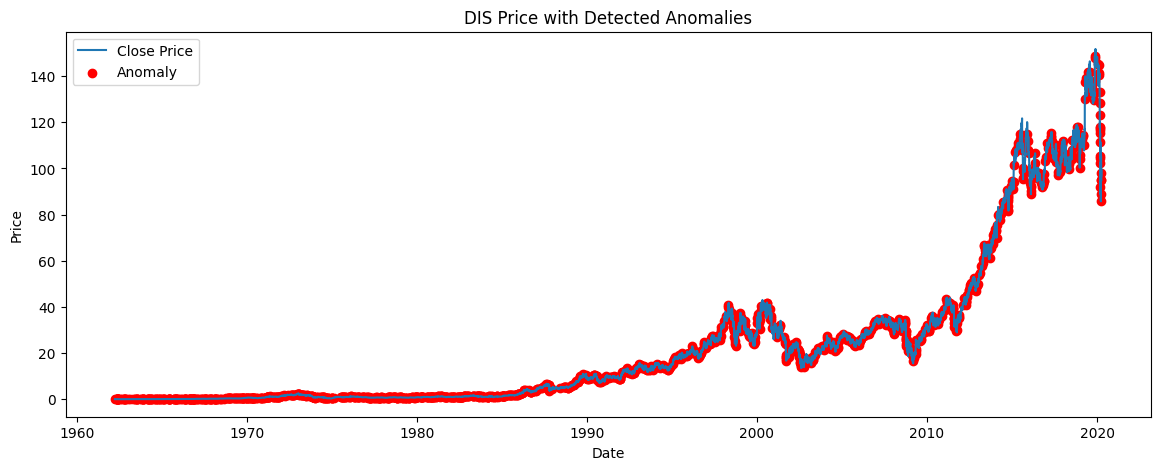

In [36]:
import matplotlib.pyplot as plt

# choose a representative stock
ticker = df['ticker'].value_counts().idxmax()
plot_df = df[df['ticker'] == ticker]

plt.figure(figsize=(14,5))
plt.plot(plot_df['date'], plot_df['close'], label='Close Price')

anoms = plot_df[plot_df['final_anomaly'] == 1]
plt.scatter(anoms['date'], anoms['close'], color='red', label='Anomaly')

plt.title(f"{ticker} Price with Detected Anomalies")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


## Market-Level Anomaly Detection



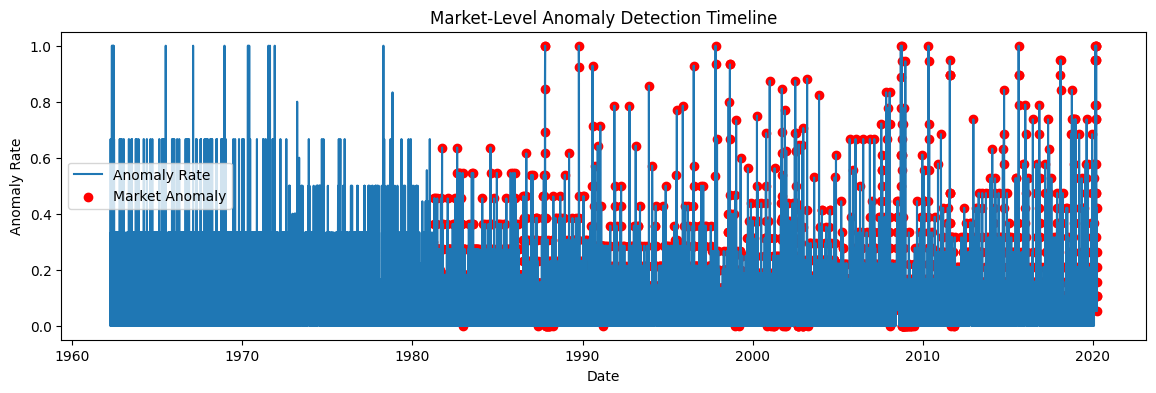

In [37]:
plt.figure(figsize=(14,4))
plt.plot(market_df['date'], market_df['anomaly_rate'], label='Anomaly Rate')

market_anoms = market_df[market_df['market_anomaly'] == 1]
plt.scatter(
    market_anoms['date'],
    market_anoms['anomaly_rate'],
    color='red',
    label='Market Anomaly'
)

plt.title("Market-Level Anomaly Detection Timeline")
plt.xlabel("Date")
plt.ylabel("Anomaly Rate")
plt.legend()
plt.show()


## Conclusion

This project implements a leakage-free, unsupervised stock market anomaly detection system using statistical rules and clustering techniques.
Stock-level anomalies are detected using rolling z-scores and K-Means clustering, while DBSCAN is applied in a subset-based walk-forward manner due to its quadratic complexity.
Market-level anomalies are identified by aggregating stock-level signals, enabling detection of systemic stress events.
The framework is interpretable, scalable, and aligned with real-world financial monitoring practices.


## Future Scope

• Incorporate news or macroeconomic indicators to explain detected anomalies.  
• Extend the framework to other markets (NYSE, global indices).  
• Replace fixed thresholds with adaptive regime-aware thresholds.  
• Use the anomaly signals as inputs to downstream risk-monitoring systems.
